<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Цель проекта** - спрогнозировать количество заказов такси на следующий час. Построить модель для такого предсказания.

 
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Описание данных**

`datetime` - время заказа;<br>
`num_orders` - количество заказов.

## Подготовка

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.dummy import DummyRegressor 
import lightgbm
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor, Pool

In [2]:
try:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]) # чтение файла с данными и сохранение в df0
except:
    data = pd.read_csv('C:\\Users\\User\\Downloads\\taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
display(data.head())
print(data.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


В данных 2 столбца:<br> 
- num_orders (количество заказов)<br> 
- datetime (время) <br><br> Пропусков нет.

In [4]:
data.sort_index(inplace=True) 
data = data.resample('1H').sum() # ресемплирование по одному часу
dayly_stat = data.resample('1D').sum() # ресемплирование по дням для анализа

Проверим в хронологическом ли порядке расположены даты и время.

In [5]:
print(data.index.is_monotonic)

True


Данные расположены в хронологическом порядке. Ресемплирование по одному часу выполнено. 

## Анализ

Разобъём  данные на тренд, сезонность и остаток. Графики сезонности и оттатков сделаем только за август.

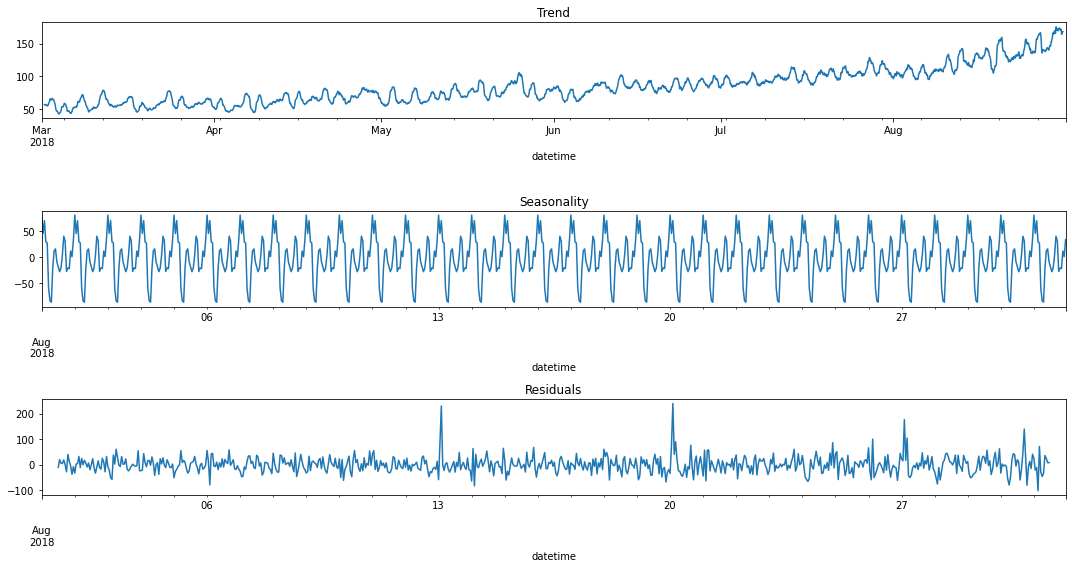

In [6]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(15, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

decomposed_2 = seasonal_decompose(data['2018-08':'2018-08'])

plt.subplot(312)
decomposed_2.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_2.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

По графику тренда видно, что количество заказов плавно увеличивается каждый месяц. <br>
На графике остатков видно увеличение количества заказов в выходные дни.<br>
Сезонный график выглядит стационарным.

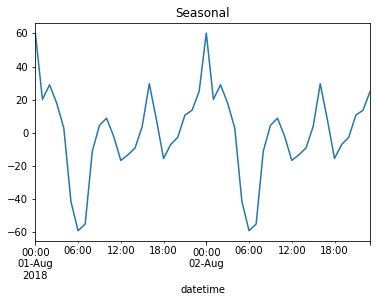

In [7]:
decomposed.seasonal['2018-08-01' : '2018-08-02'].plot(title='Seasonal');

Наблюдается сезонность в течение дня. Меньше всего заказов около 6 утра. Больше всего около полуночи.

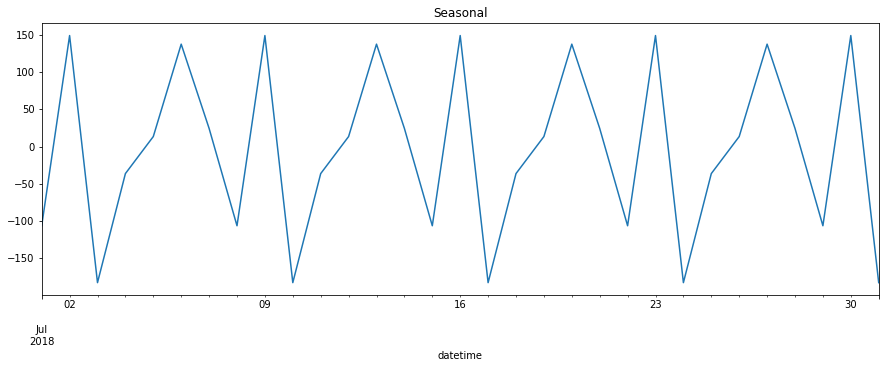

In [8]:
decomposed_d = seasonal_decompose(dayly_stat)
plt.figure(figsize=(15, 5))
decomposed_d.seasonal['2018-07-01' : '2018-07-31'].plot(title='Seasonal');

В субботу меньше всего заказов, самое большое число заказов наблюдается в пятницу.

Создадим обучающие признаки.

In [9]:
def make_features(data, max_lag, rolling_mean_size): # функция для создания обучающих признаков
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [10]:
df = make_features(data, 24, 24)

In [11]:
train, test = train_test_split(df, shuffle=False, test_size=0.2, random_state = 42)
train = train.dropna()

In [12]:
train_target = train['num_orders']
train_features = train.drop(['num_orders'], axis=1)

test_target = test['num_orders']
test_features = test.drop(['num_orders'], axis=1)

In [13]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-07-26 03:00:00
2018-07-26 04:00:00 2018-08-31 23:00:00


Для начала обучим константную модель. Предскажем новые значения предыдущими.

In [14]:
pred_previous = test['num_orders'].shift(fill_value=train['num_orders'].iloc[-1])
print("RMSE:", mean_squared_error(test['num_orders'], pred_previous, squared=False))

RMSE: 53.36807644753937


## Обучение и тестирование

**LinearRegression**

In [15]:
model = LinearRegression().fit(train_features, train_target)
prediction = model.predict(train_features)

model_test = LinearRegression().fit(test_features, test_target)
prediction_test = model_test.predict(test_features)

rmse_lr_train = mean_squared_error(train_target, prediction, squared=False)
rmse_lr_test = mean_squared_error(test_target, prediction_test, squared=False)


print("RMSE обучающей выборки:", rmse_lr_train)
print("RMSE тестовой выборки: ", rmse_lr_test)

RMSE обучающей выборки: 24.51032076330624
RMSE тестовой выборки:  38.506201342224735


**LightGBM** 

In [16]:
tscv = TimeSeriesSplit(n_splits=5)

In [17]:
param_grid = {
    'n_estimators': [1000], 
    'learning_rate': [0.015, 0.02, 0.035, 0.15],
    'max_depth': [8, 10, 12, 14],
    'num_leaves': [6, 12, 25, 50]
}

In [18]:
lgbm = lightgbm.LGBMRegressor() 

grid_lgbm = GridSearchCV(lightgbm.LGBMRegressor(random_state=42), 
                    param_grid, cv=tscv, n_jobs=-1, scoring='neg_mean_squared_error', refit=False) 
grid_lgbm.fit(train_features, train_target)
params = grid_lgbm.best_params_
lgbm_test = lightgbm.LGBMRegressor(**params, random_state = 42)


lgbm_test.fit(train_features, train_target)
pred_test = lgbm_test.predict(test_features)
print(params)
rmse_lgbm = mean_squared_error(test_target, pred_test, squared=False)
print("RMSE на тестовой выборке: ", rmse_lgbm)

{'learning_rate': 0.015, 'max_depth': 8, 'n_estimators': 1000, 'num_leaves': 6}
RMSE на тестовой выборке:  42.96233767926419


**CatBoostRegressor**

In [19]:
grid_param = {'learning_rate': [0.03, 0.1, 0.5, 0.7, 1],
        'depth': [4, 6, 10, 15, 20],
       'iterations':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
cat = CatBoostRegressor() 

grid_cat = cat.grid_search(grid_param, train_features, train_target, cv = tscv, verbose=True, plot=True)

cat.fit(train_features, train_target)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 74.5923002	test: 100.8889125	best: 100.8889125 (0)	total: 147ms	remaining: 0us

bestTest = 100.8889125
bestIteration = 0

0:	loss: 100.8889125	best: 100.8889125 (0)	total: 193ms	remaining: 48.2s
0:	learn: 70.1104813	test: 95.5144930	best: 95.5144930 (0)	total: 3.16ms	remaining: 0us

bestTest = 95.51449297
bestIteration = 0

1:	loss: 95.5144930	best: 95.5144930 (1)	total: 198ms	remaining: 24.6s
0:	learn: 46.1271801	test: 65.9590027	best: 65.9590027 (0)	total: 3.14ms	remaining: 0us

bestTest = 65.95900265
bestIteration = 0

2:	loss: 65.9590027	best: 65.9590027 (2)	total: 204ms	remaining: 16.8s
0:	learn: 36.3301139	test: 52.6136011	best: 52.6136011 (0)	total: 3.5ms	remaining: 0us

bestTest = 52.6136011
bestIteration = 0

3:	loss: 52.6136011	best: 52.6136011 (3)	total: 209ms	remaining: 12.8s
0:	learn: 28.9943102	test: 37.4080362	best: 37.4080362 (0)	total: 13.5ms	remaining: 0us

bestTest = 37.40803621
bestIteration = 0

4:	loss: 37.4080362	best: 37.4080362 (4)	total: 224ms	remain

In [22]:
cat_test = CatBoostRegressor(learning_rate = 0.7, depth = 4, iterations = 10) 

cat_test.fit(train_features, train_target)
cat_pred_test = cat_test.predict(test_features)
rmse_cat = mean_squared_error(test_target, cat_pred_test, squared=False)
print("RMSE на тестовой выборке: ", rmse_cat)

0:	learn: 27.0796720	total: 5.56ms	remaining: 50ms
1:	learn: 25.0162578	total: 11.6ms	remaining: 46.2ms
2:	learn: 24.0965507	total: 18.3ms	remaining: 42.8ms
3:	learn: 23.6629600	total: 23.2ms	remaining: 34.8ms
4:	learn: 23.4109996	total: 27.5ms	remaining: 27.5ms
5:	learn: 23.2298955	total: 33.1ms	remaining: 22.1ms
6:	learn: 22.7277135	total: 39.4ms	remaining: 16.9ms
7:	learn: 22.5076881	total: 43.9ms	remaining: 11ms
8:	learn: 22.2133408	total: 47.7ms	remaining: 5.3ms
9:	learn: 22.0846132	total: 52.5ms	remaining: 0us
RMSE на тестовой выборке:  46.09889012786444


Создадим таблицу со значениями RMSE на тестовой выборке. 

In [23]:
stats = pd.DataFrame([
                      ['Linear Regression', rmse_lr_test],
                      ['CatBoost', rmse_cat],
                      ['LGBM', rmse_lgbm]],
                    columns = ['model', 'rmse'])
display(stats)

,model,rmse
0,Linear Regression,38.506201
1,CatBoost,46.098890
2,LGBM,42.962338


Все модели показывают значение метрики RMSE ниже 48. Самое низкое значение у Linear Regression.